In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
MAIN_PATH = '/kaggle/input/teethcare-capstone-dataset'
CARIES_PATH = os.path.join(MAIN_PATH, 'caries')
DISCOLOR_PATH = os.path.join(MAIN_PATH, 'discoloration')
NORMAL_PATH = os.path.join(MAIN_PATH, 'normal')
CARIES_DISCOLOR_PATH = os.path.join(MAIN_PATH, 'caries + discoloration')

# Function penting

In [ ]:
def make_df(random_state=42):
    images = []
    labels = []
    for caries_img in os.listdir(CARIES_PATH):
        images.append(os.path.join(CARIES_PATH, caries_img))
        labels.append([1,0])

    for discolor_img in os.listdir(DISCOLOR_PATH):
        images.append(os.path.join(DISCOLOR_PATH, discolor_img))
        labels.append([0,1])

    for both_img in os.listdir(CARIES_DISCOLOR_PATH):
        images.append(os.path.join(CARIES_DISCOLOR_PATH, both_img))
        labels.append([1,1])

    for normal_img in os.listdir(NORMAL_PATH):
        images.append(os.path.join(NORMAL_PATH, normal_img))
        labels.append([0,0])

    caries_labels = [i for i, j in labels]
    discolor_labels = [j for i, j in labels]

    df = pd.DataFrame({'filename': images,
                       'caries': caries_labels,
                       'discolor': discolor_labels})

    train_df, test_df, train_df_labels, test_df_labels = train_test_split(df[['filename']],
                                                                          df[['caries', 'discolor']],
                                                                          test_size=.2,
                                                                          random_state=random_state)

    train_df = pd.concat([train_df, train_df_labels], axis=1)
    test_df = pd.concat([test_df, test_df_labels], axis=1)

    return train_df, test_df

def image_generator(target_size, batch_size=64):

    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=15,
                                       zoom_range=[-0.2, 0.2],
                                       width_shift_range=.2,
                                       height_shift_range=.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(train_df,
                                                        x_col='filename',
                                                        y_col=['caries', 'discolor'],
                                                        target_size=target_size,
                                                        color_mode='rgb',
                                                        class_mode='raw',
                                                        batch_size=batch_size)

    test_generator = test_datagen.flow_from_dataframe(test_df,
                                                      x_col='filename',
                                                      y_col=['caries', 'discolor'],
                                                      target_size=target_size,
                                                      color_mode='rgb',
                                                      class_mode='raw',
                                                      shuffle=False,
                                                      batch_size=batch_size)

    return train_generator, test_generator

def make_model(pretrained_url, trainable, input_shape):
    model = tf.keras.Sequential([
        hub.KerasLayer(pretrained_url, input_shape=input_shape, trainable=trainable),
        tf.keras.layers.Dense(512, activation='relu',
                              kernel_initializer='he_normal',
                              kernel_regularizer='l2'),
        tf.keras.layers.Dense(2, activation='sigmoid')
    ])

    if trainable:
        opt = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=.9,
                                      nesterov=True)
    else:
        opt = 'adam'

    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy', 'AUC',
                           tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall()])

    return model

def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['binary_accuracy']
    val_accuracy = history.history['val_binary_accuracy']
    precision = history.history['precision']
    val_precision = history.history['val_precision']
    recall = history.history['recall']
    val_recall = history.history['val_recall']
    auc = history.history['auc']
    val_auc = history.history['val_auc']
    epochs = range(len(loss))

    fig, ax = plt.subplots(2, 3, figsize=(15,8))
    ax[0,0].plot(epochs, loss)
    ax[0,0].plot(epochs, val_loss)
    ax[0,0].legend(['loss', 'val_loss'], loc='upper right')
    ax[0,0].set_title('Train Loss vs Val Loss')
    ax[0,1].plot(epochs, accuracy)
    ax[0,1].plot(epochs, val_accuracy)
    ax[0,1].legend(['accuracy', 'val_accuracy'], loc='lower right')
    ax[0,1].set_title('Train Acc vs Val Acc')
    ax[1,0].plot(epochs, precision)
    ax[1,0].plot(epochs, val_precision)
    ax[1,0].legend(['precision', 'val_precision'], loc='lower right')
    ax[1,0].set_title('Train Precision vs Val Precision')
    ax[1,1].plot(epochs, recall)
    ax[1,1].plot(epochs, val_recall)
    ax[1,1].legend(['recall', 'val_recall'], loc='lower right')
    ax[1,1].set_title('Train Recall vs Val Recall')
    ax[0,2].plot(epochs, auc)
    ax[0,2].plot(epochs, val_auc)
    ax[0,2].legend(['auc', 'val_auc'], loc='lower right')
    ax[0,2].set_title('Train AUC vs Val AUC')
    ax[1,2].axis('off')

    plt.show()

In [ ]:
train_df, test_df = make_df()

train_df.shape, test_df.shape

((727, 3), (182, 3))

In [ ]:
train_df.head()

,filename,caries,discolor
84,/kaggle/input/teethcare-capstone-dataset/carie...,1,0
10,/kaggle/input/teethcare-capstone-dataset/carie...,1,0
617,/kaggle/input/teethcare-capstone-dataset/norma...,0,0
250,/kaggle/input/teethcare-capstone-dataset/disco...,0,1
870,/kaggle/input/teethcare-capstone-dataset/norma...,0,0


In [ ]:
example_caries_img = train_df.loc[train_df['caries'] == 1, 'filename'].values[0]
example_discolor_img = train_df.loc[train_df['discolor'] == 1, 'filename'].values[0]
example_normal_img = train_df.loc[(train_df['caries'] == 0) & (train_df['discolor'] == 0), 'filename'].values[0]
example_both_img = train_df.loc[(train_df['caries'] == 1) & (train_df['discolor'] == 1), 'filename'].values[0]

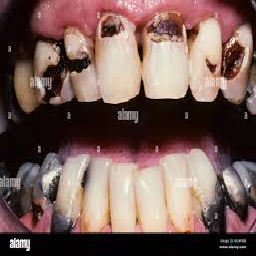

In [ ]:
tf.keras.utils.load_img(example_caries_img, target_size=(256,256))

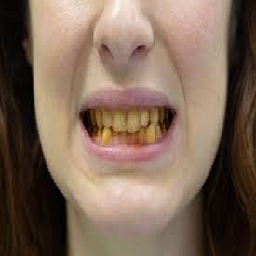

In [ ]:
tf.keras.utils.load_img(example_discolor_img, target_size=(256,256))

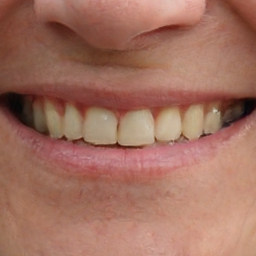

In [ ]:
tf.keras.utils.load_img(example_normal_img, target_size=(256,256))

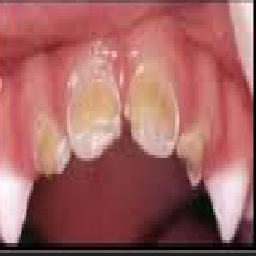

In [ ]:
tf.keras.utils.load_img(example_both_img, target_size=(256,256))

In [ ]:
train_df

,filename,caries,discolor
84,/kaggle/input/teethcare-capstone-dataset/carie...,1,0
10,/kaggle/input/teethcare-capstone-dataset/carie...,1,0
617,/kaggle/input/teethcare-capstone-dataset/norma...,0,0
250,/kaggle/input/teethcare-capstone-dataset/disco...,0,1
870,/kaggle/input/teethcare-capstone-dataset/norma...,0,0
...,...,...,...
106,/kaggle/input/teethcare-capstone-dataset/carie...,1,0
270,/kaggle/input/teethcare-capstone-dataset/disco...,0,1
860,/kaggle/input/teethcare-capstone-dataset/norma...,0,0
435,/kaggle/input/teethcare-capstone-dataset/disco...,0,1


# EfficientNet V2 M

In [ ]:
train_generator, test_generator = image_generator((224,224))
tf.keras.backend.clear_session()

EFFICIENTNET_URL = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2'

model = make_model(EFFICIENTNET_URL, trainable=False, input_shape=(224,224,3))

model.summary()

Found 727 validated image filenames.
Found 182 validated image filenames.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              53150388  
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 53,807,286
Trainable params: 656,898
Non-trainable params: 53,150,388
_________________________________________________________________


In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('/kaggle/working/checkpoint_effnetv2m/model-trFalse-{val_auc:.4f}.h5', verbose=1,
                                                      save_best_only=True, monitor='val_auc',
                                                      mode='max')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_binary_accuracy',
    factor=0.1,
    patience=5,
    cooldown=2,
    min_lr=0.0001,
    verbose=1,
    mode='auto')
history = model.fit(train_generator, epochs=100,
                    validation_data=test_generator,
                    callbacks=[checkpoint, reduce_lr])

Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 4.8099 - binary_accuracy: 0.7579 - auc: 0.7737 - precision: 0.6426 - recall: 0.4465
Epoch 1: val_auc improved from -inf to 0.81862, saving model to /kaggle/working/checkpoint_effnetv2m/model-trFalse-0.8186.h5
12/12 [==============================] - 15s 1s/step - loss: 4.8099 - binary_accuracy: 0.7579 - auc: 0.7737 - precision: 0.6426 - recall: 0.4465 - val_loss: 4.0075 - val_binary_accuracy: 0.7418 - val_auc: 0.8186 - val_precision: 0.8235 - val_recall: 0.2414 - lr: 0.0010
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 3.4863 - binary_accuracy: 0.7620 - auc: 0.7798 - precision: 0.6535 - recall: 0.4510
Epoch 2: val_auc improved from 0.81862 to 0.83567, saving model to /kaggle/working/checkpoint_effnetv2m/model-trFalse-0.8357.h5
12/12 [==============================] - 15s 1s/step - loss: 3.4863 - binary_accuracy: 0.7620 - auc: 0.7798 - precision: 0.6535 - recall: 0.4510 - val_loss: 2.9037 - val_b

3/3 [==============================] - 4s 342ms/step - loss: 0.6215 - binary_accuracy: 0.8242 - auc: 0.8898 - precision: 0.7321 - recall: 0.7069

Loss: 0.6215
Accuracy: 82.42%
AUC: 88.98%
Precision: 73.21%
Recall: 70.69%


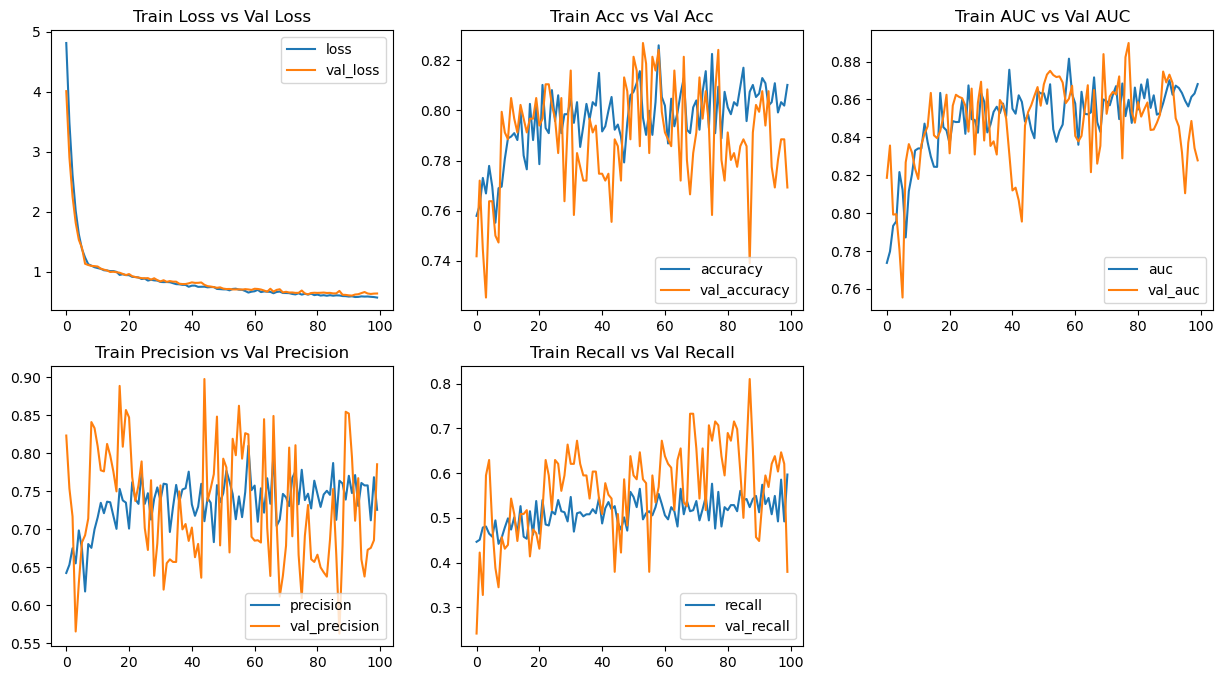

In [ ]:
best_model = tf.keras.saving.load_model('/kaggle/working/checkpoint_effnetv2m/model-trFalse-0.8898.h5',
                                        custom_objects={'KerasLayer': hub.KerasLayer})
loss, acc, auc, prec, rec = best_model.evaluate(test_generator)

print(f'\nLoss: {loss:.4f}')
print(f'Accuracy: {acc*100:.2f}%')
print(f'AUC: {auc*100:.2f}%')
print(f'Precision: {prec*100:.2f}%')
print(f'Recall: {rec*100:.2f}%')

plot_history(history)